In [27]:
print(__doc__)
# author: Gael Varoquaux <gael.varoquaux@inria.fr>
# License: BSD 3 clause
# Copyright: INRIA

import numpy as np
import scipy.stats as ss
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, graphical_lasso, GraphicalLasso
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.utils.extmath import fast_logdet

#cv_notest:
from sklearn.utils.validation import check_random_state, check_array
from sklearn.covariance.empirical_covariance_ import empirical_covariance
from sklearn.model_selection import check_cv, cross_val_score
from collections.abc import Sequence
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._joblib import Parallel, delayed
from sklearn.covariance.graph_lasso_ import graphical_lasso_path
from sklearn.covariance import log_likelihood

Automatically created module for IPython interactive environment


In [120]:
def rank_to_normal(X, c=(3/8)):
    # Standard quantile function each feature
    rank = ss.rankdata(X, method="average")
    N = len(rank)
    Z = (rank - c) / (N - 2*c + 1)
    return ss.norm.ppf(Z, loc=0, scale=1)

In [30]:
# #############################################################################
# Generate the data
# Generate the data
n_samples = 10
n_features = 2

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=prng)


#prec = np.identity(n_features)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
random_noise = np.random.normal(0, 1, n_samples*n_features).reshape(n_samples,n_features)
X = X + random_noise
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [121]:
#inverse rank normalize the data 
#Get rank, ties are averaged

Y = np.zeros((n_samples, n_features))
for i in range(n_features):
    Y[:,i] = rank_to_normal(X[:, i])


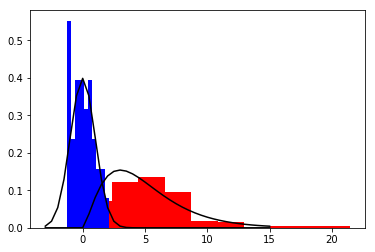

In [21]:
#Empirical 
emp_cov = np.cov(X.T, bias=1)
emp_prec = linalg.inv(emp_cov)

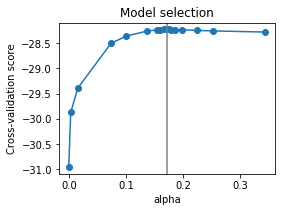

In [22]:
model = GraphicalLassoCV(cv=5)
model.fit(X)
cv_cov = model.covariance_
cv_prec = model.precision_

# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(model.cv_alphas_, np.mean(model.grid_scores_, axis=1), 'o-')
plt.axvline(model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()

In [23]:
def graphical_lasso_path_z(X, alphas, cov_init=None, X_test=None, mode='cd',
                         tol=1e-4, enet_tol=1e-4, max_iter=100, verbose=False):
    """l1-penalized covariance estimator along a path of decreasing alphas
    Read more in the :ref:`User Guide <sparse_inverse_covariance>`.
    Parameters
    ----------
    X : 2D ndarray, shape (n_samples, n_features)
        Data from which to compute the covariance estimate.
    alphas : list of positive floats
        The list of regularization parameters, decreasing order.
    cov_init : 2D array (n_features, n_features), optional
        The initial guess for the covariance.
    X_test : 2D array, shape (n_test_samples, n_features), optional
        Optional test matrix to measure generalisation error.
    mode : {'cd', 'lars'}
        The Lasso solver to use: coordinate descent or LARS. Use LARS for
        very sparse underlying graphs, where p > n. Elsewhere prefer cd
        which is more numerically stable.
    tol : positive float, optional
        The tolerance to declare convergence: if the dual gap goes below
        this value, iterations are stopped.
    enet_tol : positive float, optional
        The tolerance for the elastic net solver used to calculate the descent
        direction. This parameter controls the accuracy of the search direction
        for a given column update, not of the overall parameter estimate. Only
        used for mode='cd'.
    max_iter : integer, optional
        The maximum number of iterations.
    verbose : integer, optional
        The higher the verbosity flag, the more information is printed
        during the fitting.
    Returns
    -------
    covariances_ : List of 2D ndarray, shape (n_features, n_features)
        The estimated covariance matrices.
    precisions_ : List of 2D ndarray, shape (n_features, n_features)
        The estimated (sparse) precision matrices.
    scores_ : List of float
        The generalisation error (log-likelihood) on the test data.
        Returned only if test data is passed.
    """
    
    #cv = check_cv(self.cv, y, classifier=False)

        
    inner_verbose = max(0, verbose - 1)
    emp_cov = empirical_covariance(X)
    if cov_init is None:
        covariance_ = emp_cov.copy()
    else:
        covariance_ = cov_init
    covariances_ = list()
    precisions_ = list()
    scores_ = list()
    z_scores_ = list()
    if X_test is not None:
        test_emp_cov = empirical_covariance(X_test)

    for alpha in alphas:
        try:
            # Capture the errors, and move on
            covariance_, precision_ = graphical_lasso(
                emp_cov, alpha=alpha, cov_init=covariance_, mode=mode, tol=tol,
                enet_tol=enet_tol, max_iter=max_iter, verbose=inner_verbose)
            covariances_.append(covariance_)
            precisions_.append(precision_)
            
            z_score = log_likelihood(emp_cov, precision_)
            z_scores_.append(z_score)
            if X_test is not None:
                this_score = log_likelihood(test_emp_cov, precision_)
        except FloatingPointError:
            this_score = -np.inf
            covariances_.append(np.nan)
            precisions_.append(np.nan)
        if X_test is not None:
            if not np.isfinite(this_score):
                this_score = -np.inf
            scores_.append(this_score)
        if verbose == 1:
            sys.stderr.write('.')
        elif verbose > 1:
            if X_test is not None:
                print('[graphical_lasso_path] alpha: %.2e, score: %.2e'
                      % (alpha, this_score))
            else:
                print('[graphical_lasso_path] alpha: %.2e' % alpha)
    if X_test is not None:
        return covariances_, precisions_, scores_, z_scores_
    return covariances_, precisions_, z_scores_

In [24]:

alpha_array = np.arange(0.1, 3, 0.1)
m = graphical_lasso_path_z(X, alpha_array)

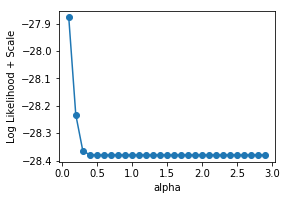

In [25]:
like = m[2]
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(alpha_array, like, 'o-')
#plt.axvline(alpha_bic, color='.5')
plt.title('')
plt.ylabel(  'Log Likelihood + Scale')
plt.xlabel('alpha')

plt.show()

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test= train_test_split(X, test_size=0.2)

#cv = check_cv(X, classifier=False)

In [114]:
from sklearn.covariance.graph_lasso_ import graphical_lasso_path

m2 = graphical_lasso_path_z(X=X_train, alphas= alpha_array, X_test=X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:262: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.041e-03
  % (max_iter, d_gap), ConvergenceWarning)


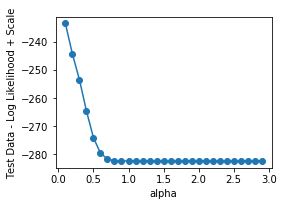

In [115]:
like = m2[2]
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(alpha_array, like, 'o-')
#plt.axvline(alpha_bic, color='.5')
plt.title('')
plt.ylabel(  'Test Data - Log Likelihood + Scale')
plt.xlabel('alpha')

plt.show()

In [63]:
cv = 5
y = None
cv = check_cv(cv, y, classifier=False)
max_iter = 100
enet_tol=1e-4

this_path = ((graphical_lasso_path)(X[train], alphas=model.cv_alphas_,
                                                X_test=X[test], mode='cd',
                                                tol=1e-4,
                                                enet_tol=enet_tol,
                                                max_iter=int(.1 *
                                                             max_iter),
                                                verbose=False)
                  for train, test in cv.split(X))

In [64]:
covs, _, scores = zip(*this_path)


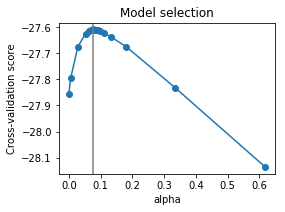

In [85]:


# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(model.cv_alphas_, scores[0], 'o-')
plt.axvline(model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()


In [81]:
z = zip(*scores, *covs)

In [82]:
s, c = zip(z)

ValueError: too many values to unpack (expected 2)

In [66]:
list(zip(z))

[((-28.135443667174975,
   -28.493248762379523,
   -28.479067917261577,
   -28.540661149020377,
   -28.204722323280997),),
 ((-27.83201445073801,
   -28.20148239005291,
   -28.16723938456706,
   -28.302439334071284,
   -27.945671843410707),),
 ((-27.675486639149682,
   -28.053089549400696,
   -27.963101454097064,
   -28.17654229534694,
   -27.796635068657608),),
 ((-27.638242864739418,
   -28.02022514199676,
   -27.91981977348789,
   -28.14788590937414,
   -27.757014283229825),),
 ((-27.623275578651075,
   -28.00853156894737,
   -27.904132901824283,
   -28.137826510671573,
   -27.74177493007234),),
 ((-27.615886303135653,
   -28.005073395591054,
   -27.896872028017285,
   -28.1333385385948,
   -27.735483686212174),),
 ((-27.6125957787683,
   -28.002886216768868,
   -27.894389121838444,
   -28.13221075853381,
   -27.7349608379478),),
 ((-27.61053659753475,
   -27.999848965205103,
   -27.892412965189116,
   -28.131929082693446,
   -27.734076234525197),),
 ((-27.609519673465964,
   -27.99